In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("cs1090b_hw3.ipynb")

# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> Data Science 2: Advanced Topics in Data Science 
## Homework 3: Convolutional Neural Networks


**Harvard University**<br/>
**Spring 2025**<br/>
**Instructors**: Pavlos Protopapas, Natesh Pillai, and Chris Gumb


<hr style="height:2pt">

In [2]:
# RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get(
    "https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/"
    "content/styles/cs109.css"
).text
HTML(styles)

In [3]:
try:
    import tensorflow_datasets as tfds
except ImportError:
    print("Installing tensorflow-datasets...")
    !pip install -q --no-warn-script-location tensorflow-datasets==4.9.4
    print("Done!\n⚠️ Please restart kernel for changes to take effect (Kernel > Restart)")

In [4]:
import os
import pathlib
import time
import zipfile
import random
import imageio
from matplotlib import cm
import matplotlib.pyplot as plt
import numpy as np
import pickle
import time
import tarfile
import gdown
from PIL import Image
import requests
import scipy.ndimage as ndimage
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers
from tensorflow.keras.layers import Activation, BatchNormalization
from tensorflow.keras.layers import Conv2D, Dense, Dropout, GaussianNoise
from tensorflow.keras.layers import Flatten, Input, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.regularizers import L1, L2
from tensorflow.keras.callbacks import EarlyStopping, LambdaCallback, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, BatchNormalization
import tqdm

2025-03-18 08:17:50.076312: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-18 08:17:50.076355: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-18 08:17:50.097834: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-18 08:17:50.157939: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
# TF GPU check
print(f"tensorflow version {tf.__version__}")
print(f"Available GPUs: \n{tf.config.list_logical_devices('GPU')}\n")

tf.random.set_seed(2266)

tensorflow version 2.15.0
Available GPUs: 
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]



2025-03-18 08:18:05.931342: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 20763 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:31:00.0, compute capability: 8.9


In [6]:
# measure notebook runtime
time_start = time.time()

<div style = "background: lightsalmon; border: thin solid black; border-radius: 2px; padding: 5px">

### Instructions
- To submit your notebook, follow the instructions given in on the Canvas assignment page.
- Plots should be legible and interpretable *without having to refer to the code that generated them*. They should includelabels for the $x$- and $y$-axes as well as a descriptive title and/or legend when appropriate.
- When asked to interpret a visualization, do not simply describe it (e.g., "the curve has a steep slope up"), but instead explain what you believe the plot *means*.
- Autograding tests are mostly to help you debug. The tests are not exhaustive so simply passing all tests may not be sufficient for full credit.
- The use of *extremely* inefficient or error-prone code (e.g., copy-pasting nearly identical commands rather than looping) may result in only partial credit.
- We have tried to include all the libraries you may need to do the assignment in the imports cell provided below. Please get course staff approval before importing any additional 3rd party libraries.
- Enable scrolling output on cells with very long output.
- Feel free to add additional code or markdown cells as needed.
- Ensure your code runs top to bottom without error and passes all tests by restarting the kernel and running all cells (note that this can take a few minutes). 
- **You should do a "Restart Kernel and Run All Cells" before submitting to ensure (1) your notebook actually runs and (2) all output is visible**
</div>


<a id="contents"></a>

## Notebook Contents

- [**PART 1: Building a Basic CNN Classifier**](#part1)

- [**PART 2: Regression with CNN**](#part2)

- [**PART 3: Image Segmentation**](#part3)

## About this Homework

In this homework, we will explore Convolutional Neural Networks (CNNs).

- In [PART 1](#part1), we will begin by building a CNN to classify CIFAR-10 images, a standard pedagogical problem.


- Then, in [PART 2](#part2), we will then see that CNNs are great for more than just classifying our images! They can serve as image input processing for a variety of tasks, as we will show by training a network on the CelebA dataset to rotate images of faces upright.

- Finally, [PART 3](#part3), we will look at a dataset of pet photos for image segmentation. This is a classification problem. But instead of assigning class probablities to the image as a whole, we assign class probabilities for each individual pixel, identifying what regions of the image belong to each class (e.g., 'pet' or 'background').  

**IMPORTANT NOTES:**

- Convolutional neural networks are computationally intensive.
- **We highly recommend that you train your model on a system using GPUs. For this, we recommend using the [GPU-enabled Jupyter environment](https://ood.huit.harvard.edu/pun/sys/dashboard/batch_connect/sys/ood-jupyterlab-spack-conda/cs1090b/session_contexts/new) provided to you as part of this course.** 
- Models that take hours to train on CPUs can be trained in just minutes when using GPUs.
- **To avoid getting frustrated by having to re-train your models every time you run your notebook, you should save your trained model weights for later use.** Model history dictionaries can also be saved to disk with `pickle` and checked with an `if not` condition. This is a great way to check if the model weights exist before training, preventing redundant retraining. Please, think of the penguins! 🐧

**KERNEL CRASHES:**

If your kernel crashes as you attempt to train your model, please check the following items:
- Models with too many parameters might not fit in GPU memory. Try reducing the size of your model.
- A large `batch_size` will attempt to load too many images in GPU memory. Avoid using a very large batch size.
- Avoid creating multiple copies of the data.

<a id="part1"></a>
    
<!-- <div class="alert alert-block alert-danger" style="color:black;background-color:#E7F4FA"> -->

# PART 1: Building a Basic CNN Model


<a id="part1intro"></a>

## Overview

[Return to contents](#contents)

In this question, you will use Keras to create a convolutional neural network for predicting the "type of object" shown in each image from the [CIFAR-10](https://keras.io/datasets/#cifar10-small-image-classification) dataset. This dataset contains 50,000 32x32 colored training images and 10,000 test images of the same size, with a total of 10 classes, representing the "type of object" shown in each image.

<a id="q11"></a>



<!-- BEGIN QUESTION -->

<div class='exercise'>
    
<b>1.1 Loading CIFAR-10 and Constructing the Model</b>
<hr>
<b>Q1.1.1 - Preprocessing</b>

<a id="q111"></a>

Load the CIFAR-10 dataset from the `tensorflow.keras.datasets.cifar10` import shown at the top of this notebook. Perform any preprocessing of the data that might be required for this dataset.
    
You may choose to load cifar10 as either a numpy array or as a Tensorflow Dataset.
</div>

In [7]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# normalizing image data
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# one-hot encode classes
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

# augment data
datagen = ImageDataGenerator(
    rotation_range=15, 
    width_shift_range=0.1, 
    height_shift_range=0.1,  
    horizontal_flip=True, 
    zoom_range=0.1 
)

datagen.fit(x_train)

print("Training data shape:", x_train.shape)
print("Training labels shape:", y_train.shape)
print("Test data shape:", x_test.shape)
print("Test labels shape:", y_test.shape)

Training data shape: (50000, 32, 32, 3)
Training labels shape: (50000, 10)
Test data shape: (10000, 32, 32, 3)
Test labels shape: (10000, 10)


<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q1.1.2</b>

<a id="q112"></a>

Construct a classification model architecture using a combination of the following layers: Conv2D, MaxPooling2D, Dense, Dropout and Flatten. The layers don’t necessarily need to be in this order, and you can use as many of these types of layers as you’d like. 

  - You may choose to construct your own implementation of a well-known architecture like AlexNet or VGG16, or you can create an architecture of your own devising.

  - However, you MUST code the network yourself and not use a pre-written implementation. 

  - You must have multiple Conv2D layers.
</div>

In [8]:
# VGG16-inspired model
def create_vgg16_model(num_filters=64):
    model = Sequential([
        Conv2D(num_filters, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)),
        Conv2D(num_filters, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        
        Conv2D(num_filters * 2, (3, 3), activation='relu', padding='same'),
        Conv2D(num_filters * 2, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        
        Conv2D(num_filters * 4, (3, 3), activation='relu', padding='same'),
        Conv2D(num_filters * 4, (3, 3), activation='relu', padding='same'),
        Conv2D(num_filters * 4, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        
        Conv2D(num_filters * 8, (3, 3), activation='relu', padding='same'),
        Conv2D(num_filters * 8, (3, 3), activation='relu', padding='same'),
        Conv2D(num_filters * 8, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(10, activation='softmax')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model
model = create_vgg16_model(num_filters=64)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        36928     
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 64)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 128)       147584    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 8, 8, 128)         0         
 g2D)                                                   

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q1.2 Model parameter growth</b>

<a id="q12"></a>

How does the number of total parameters change (e.g. linearly, exponentially, etc.) as the number of filters per layer increases (your model should have at least 2 Conv layers)? You can find this empirically by constructing multiple models with the same type of architecture and increasing the number of filters. Generate a plot showing the relationship and explain why it has this relationship. 

**HINT:** Completing this question is far easier if you write a function that generates your desired architecture in 1.1.2, with arguments that allow you to easily rebuild the architecture with varying numbers of filters per layer.
    </div>

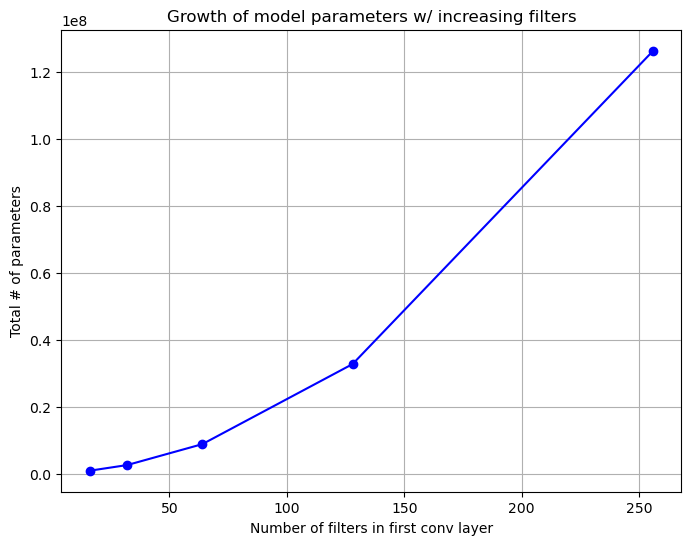

In [9]:
# testing different filter sizes
filter_sizes = [16, 32, 64, 128, 256]
num_params = []

for filters in filter_sizes:
    model = create_vgg16_model(filters)
    num_params.append(model.count_params())

# plotting parameter growth
plt.figure(figsize=(8, 6))
plt.plot(filter_sizes, num_params, marker='o', linestyle='-', color='b')
plt.xlabel('Number of filters in first conv layer')
plt.ylabel('Total # of parameters')
plt.title('Growth of model parameters w/ increasing filters')
plt.grid()
plt.show()


We observe that the total number of parameters in a CNN model appears to grow exponentially as the number of filters in the first convolutional layer increases. This happens because each Conv2D layer has parameters = (filter height * filter width * input channels + 1) * number of filters where the +1 accounts for the bias term. As the number of filters increases, the flattened output that feeds into the Dense layers also expands significantly which causes rapid parameter growth growth. Dense layers contribute the most to this expansion as they have fully connected neurons following: parameters = input size * neurons + bias where input size depends on the number of filters from previous layers. BatchNormalization layers also add scaling and shifting parameters per channel, further increasing complexity + parameter #.

<a id="q13"></a>


<!-- BEGIN QUESTION -->

<div class='exercise'>

<b>1.3 Choose a model, train and evaluate it</b>
<hr>    
<b>Q1.3.1</b>

<a id="q131"></a>

Print the model summary for your chosen architecture, and report the total number of parameters. Then train your model using the CIFAR-10 dataset, and `validation_split=0.2`. You can choose to train your model for as long as you'd like, but you should aim for at least 10 epochs. Report your validation and test accuracies. You can achieve a test accuracy of over 75% in about 6 minutes of training.

**Hint:** It would be helpful to add code which either saves your model to a local directory if it is the first time you're training it or loads your model if a saved file version currently exists in that directory. This will not only help save time when you rerun your notebook, but it will also ensure reproducible results in the rest of Part 1.
</div>

In [10]:
model_path = "vgg16_cifar10_model.h5"

model = create_vgg16_model(num_filters=64)
# split dataset
val_split = 0.2
split_index = int(len(x_train) * (1 - val_split))
x_train_new, x_val = x_train[:split_index], x_train[split_index:]
y_train_new, y_val = y_train[:split_index], y_train[split_index:]
    
# separate data generators for training and validation
train_generator = datagen.flow(x_train_new, y_train_new, batch_size=64)
val_generator = datagen.flow(x_val, y_val, batch_size=64)
    
history = model.fit(train_generator,
                    validation_data=val_generator,
                    epochs=30,
                    verbose=1)
    
model.save(model_path)

test_loss, test_acc = model.evaluate(x_test, y_test, verbose=1)


Epoch 1/30


2025-03-18 08:18:10.143370: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2025-03-18 08:18:12.650988: I external/local_xla/xla/service/service.cc:168] XLA service 0x151eb8ce51d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-03-18 08:18:12.651019: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA L4, Compute Capability 8.9
2025-03-18 08:18:12.659384: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1742300292.935060    9131 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


625/625 [==============================] - 22s 24ms/step - loss: 1.9828 - accuracy: 0.2393 - val_loss: 1.6284 - val_accuracy: 0.3906
Epoch 2/30
625/625 [==============================] - 15s 24ms/step - loss: 1.5977 - accuracy: 0.4032 - val_loss: 1.4703 - val_accuracy: 0.4498
Epoch 3/30
625/625 [==============================] - 15s 24ms/step - loss: 1.4123 - accuracy: 0.4857 - val_loss: 1.3236 - val_accuracy: 0.5289
Epoch 4/30
625/625 [==============================] - 15s 23ms/step - loss: 1.2593 - accuracy: 0.5530 - val_loss: 1.1911 - val_accuracy: 0.5644
Epoch 5/30
625/625 [==============================] - 15s 24ms/step - loss: 1.1472 - accuracy: 0.5974 - val_loss: 1.0312 - val_accuracy: 0.6337
Epoch 6/30
625/625 [==============================] - 15s 24ms/step - loss: 1.0597 - accuracy: 0.6312 - val_loss: 1.0213 - val_accuracy: 0.6329
Epoch 7/30
625/625 [==============================] - 15s 23ms/step - loss: 0.9826 - accuracy: 0.6590 - val_loss: 0.9304 - val_accuracy: 0.6710
Epo

/shared/courseSharedFolders/142601outer/142601/cs109b/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


313/313 [==============================] - 1s 3ms/step - loss: 0.5399 - accuracy: 0.8359


In [11]:
print("Test accuracy:", test_acc)
print("Val accuracy:",history.history['val_accuracy'][-1])

Test accuracy: 0.8359000086784363
Val accuracy: 0.8300999999046326


<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q1.3.2</b>

<a id="q132"></a> 

Plot the training loss and accuracy per epoch (both train and validation) for your chosen architecture.

</div>

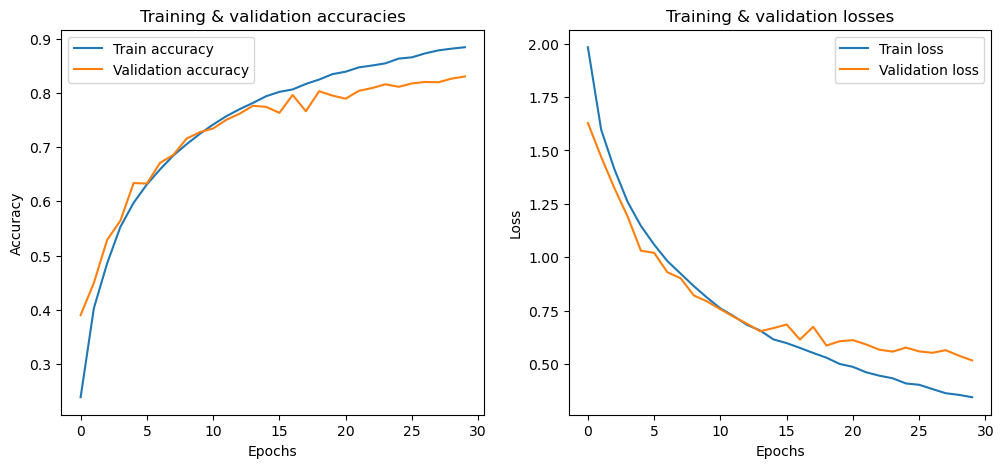

In [12]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training & validation accuracies')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & validation losses')
plt.legend()

plt.show()


<a id="part2"></a>
    
<!-- <div class="alert alert-block alert-danger" style="color:black;background-color:#E7F4FA"> -->

# PART 2: Regression with CNN 
<a id="part2intro"></a>
## Overview

[Return to contents](#contents)

**In this problem we will construct a neural network to predict how far a face is from being "upright"**. 

**Image orientation estimation**

Image orientation estimation with convolutional networks was first implemented in 2015 by Fischer, Dosovitskiy, and Brox in a paper titled ["Image Orientation Estimation with Convolutional Networks"](https://lmb.informatik.uni-freiburg.de/Publications/2015/FDB15/image_orientation.pdf). In that paper, the authors trained a network to straighten a wide variety of images using the [Microsoft COCO dataset](https://cocodataset.org/#home). 

**The modified CelebA dataset**

In order to have a reasonable training time for a homework, we will be working on a subset of the problem where we just straighten images of faces. To do this:

- We will be using the [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset of celebrity faces, where we assume that professional photographers have taken level pictures;


- The training will be supervised, with a rotated image (up to $\pm 60^\circ$) as an input, and the amount (in degrees) that the image has been rotated as a target. 

<a id="q21"></a>


<!-- BEGIN QUESTION -->

<div class='exercise'>
<b>2.1 Data preparation</b>
<hr>
<b>Q2.1.1</b>

<a id="q211"></a>

**Loading the CelebA Dataset.** Run the cells provided to automatically load the CelebA dataset if you are on the cluster. Otherwise it will be downloaded for you. This is a TensorFlow Dataset object. [TensorFlow Datasets](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) are objects that behave like Python generators, allowing you to take elements (either input/target tuples or feature dictionaries) until you have gone through the entire dataset. Note how this is different from PART 1 where the entire dataset was loaded in as an array. Datasets also allow you to pipeline transformations to be applied to the elements, resulting in a new transformed Dataset (like `train_rot_ds`).

  - **All you need to do is run the provided code**:

    - The creation of the normalization/rotation/resize pipeline has been done for you, resulting in train dataset `train_rot_ds` and validation dataset `test_rot_ds`. 
    
**Note:** You do not need to create a separate validation anywhere in Part 2. We are just using train and test with no validation for simplicity.
    </div>

In [13]:
# Define paths and URL
cluster_data_dir = os.path.expanduser('~/142601/data/hw3')
local_data_dir = './data'
gdrive_url = 'https://drive.google.com/uc?id=13C6qxNmKlkW8ZRcFcc3N0GhmBeww8HDI'

# Check for cluster data directory first
if os.path.exists(cluster_data_dir):
    print(f"Using cluster dataset")
    data_dir = cluster_data_dir
    download = False
else:
    # Not on cluster, prepare local directory
    os.makedirs(local_data_dir, exist_ok=True)
    
    # If not already downloaded, get it from Google Drive
    if not os.path.exists(os.path.join(local_data_dir, 'celeb_a')):
        print("Downloading dataset...")
        targz_path = os.path.join(local_data_dir, 'celeb_a.tar.gz')
        gdown.download(gdrive_url, targz_path)
        
        # Extract archive
        with tarfile.open(targz_path) as tar:
            tar.extractall(path=local_data_dir)
        os.remove(targz_path)
    
    data_dir = local_data_dir
    download = False

# Load the dataset
train_celeb, test_celeb = tfds.load(
    "celeb_a",
    split=["train", "test"],
    shuffle_files=False,
    data_dir=data_dir,
    download=download,
)

Using cluster dataset


In [14]:
def normalize_image(img):
    """Normalize image to [0, 1] range."""
    return tf.cast(img, tf.float32)/255.

@tf.function
def scipy_rotate(image, angle):
    """Efficient rotation using SciPy's ndimage."""
    rotated = tf.numpy_function(
        lambda img, ang: ndimage.rotate(img, ang, reshape=False, order=1),
        [image, angle],
        tf.float32
    )
    rotated.set_shape(image.shape)
    rotated = tf.image.resize_with_crop_or_pad(rotated, 140, 120)
    return rotated

@tf.function
def tf_random_rotate_helper(image):
    """Apply random rotation."""
    image = normalize_image(image)
    deg = tf.random.uniform([], -60.0, 60.0)
    rotated = scipy_rotate(image, deg)
    return rotated, deg

@tf.function
def tf_random_rotate_image(element):
    """Process dataset element."""
    image = element['image']
    rotated, angle = tf_random_rotate_helper(image)
    rotated.set_shape((140, 120, 3))
    return rotated, angle

In [15]:
# Pipeline for creating randomly rotated images with their target labels being 
# the amount they were rotated, in degrees.
train_rot_ds = train_celeb.map(
    tf_random_rotate_image,
    num_parallel_calls=tf.data.AUTOTUNE)

test_rot_ds = test_celeb.map(
    tf_random_rotate_image,
    num_parallel_calls=tf.data.AUTOTUNE)

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q2.1.2</b>

<a id="q212"></a>

**Taking a look.** In a grid of subplots, plot at least 4 rotated images from `train_rot_ds` with the titles being the amount the images have been rotated. The floating point numbers in the titles should have a reasonable number of digits. **HINT:** one way to get a few image+label tuples from the Dataset is with `train_rot_ds.take(4)`. Check the [TensorFlow Datasets documentation](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) for more information.

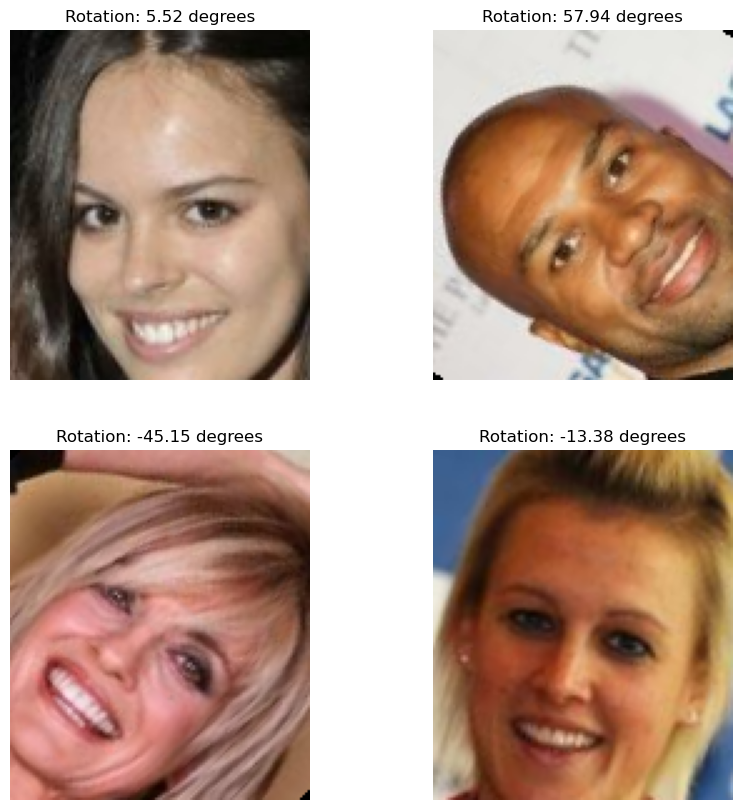

In [16]:
def plot_rotated_images(dataset, num_images=4):
    plt.figure(figsize=(10, 10))
    for i, (image, label) in enumerate(dataset.take(num_images)):
        ax = plt.subplot(2, 2, i + 1)
        plt.imshow((image.numpy() * 255).astype("uint8"))
        plt.title(f"Rotation: {label.numpy():.2f} degrees")
        plt.axis("off")
    plt.show()

plot_rotated_images(train_rot_ds, num_images=4)


<a id="q22"></a>


<!-- BEGIN QUESTION -->

<div class='exercise'>
<b>2.2 Building and training your CNN</b>
<hr>
<a id="q221"></a>
<b>Q2.2.1 Compiling your model.</b>
    
Construct a model with multiple Conv layers and any other layers you think would help. Be certain to print your model summary as always. Feel free to experiment with architectures and number of parameters if you wish to get better performance or better training speed. You certainly don't need more than a few million parameters; we have been able to do it with substantially fewer. 
    
**Note:** Again, it is fine to attempt your own implementation of a well-known architecture, but you may not load any pre-constructed models. The network must be built layer-by-layer from your own code.
    </div>

In [17]:
from tensorflow import keras
from tensorflow.keras import layers

def build_deepcnn_model(input_shape=(140, 120, 3)):
    inputs = keras.Input(shape=input_shape)
    
    # VGG16-like convolutional layers
    conv1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D((2, 2))(conv1)
    
    conv2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D((2, 2))(conv2)
    
    conv3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = layers.MaxPooling2D((2, 2))(conv3)
    
    conv4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = layers.MaxPooling2D((2, 2))(conv4)
    
    conv5 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)
    conv5 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)
    pool5 = layers.MaxPooling2D((2, 2))(conv5)
    
    flatten = layers.Flatten()(pool5)
    dense1 = layers.Dense(4096, activation='relu')(flatten)
    dense1 = layers.Dropout(0.5)(dense1)
    
    dense2 = layers.Dense(4096, activation='relu')(dense1)
    dense2 = layers.Dropout(0.5)(dense2)
    
    output = layers.Dense(1, activation='linear')(dense2)  # linear activation for regression
    
    model = keras.Model(inputs, output, name="model_vgg16")
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.0001),
        loss=tf.keras.losses.Huber(delta=1.0),  # more robust than MSE
        metrics=['mae']
    )
    
    return model

model = build_deepcnn_model()

model.summary()

Model: "model_vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 140, 120, 3)]     0         
                                                                 
 conv2d_70 (Conv2D)          (None, 140, 120, 64)      1792      
                                                                 
 conv2d_71 (Conv2D)          (None, 140, 120, 64)      36928     
                                                                 
 max_pooling2d_28 (MaxPooli  (None, 70, 60, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_72 (Conv2D)          (None, 70, 60, 128)       73856     
                                                                 
 conv2d_73 (Conv2D)          (None, 70, 60, 128)       147584    
                                                       

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q2.2.2 Training your model</b>

<a id="q222"></a>

Train your model. Please note that the `model.fit()` argument syntax is a little different when working with Datasets instead of numpy arrays; take a look at the [tf.keras.Model](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit) documentation. Be sure to also pass the test data as validation data. When passing `train_rot_ds` to `.fit()`, you will find it useful to use pipelines to [batch](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#batch) the data. You can also experiment with [prefetching](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch) batches/elements from the dataset, which may allow you to speed up iterations by a few percent. Finally, while dry-running and prototyping your model, you may find it useful to [take](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#take) a subset of the data to speed up experimentation. However, your final model MUST be trained on all the available training data! You should achieve test MSEs of less than 9, corresponding roughly to $\pm 3^\circ$ accuracy in predicting the rotations on the test set. This can be achieved in just 2-3 epochs, though you are free to train as long as you want.
    </div>

In [18]:
batch_size = 64
train_ds = train_rot_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_ds = test_rot_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

history = model.fit(train_ds, validation_data=test_ds, epochs=3, verbose=1)

test_loss, test_mae = model.evaluate(test_ds, verbose=1)
print("Test MSE:", test_loss)
print("Test MAE:", test_mae)


Epoch 1/3
2544/2544 [==============================] - 451s 172ms/step - loss: 3.3017 - mae: 3.7499 - val_loss: 1.7215 - val_mae: 2.1786
Epoch 2/3
2544/2544 [==============================] - 435s 171ms/step - loss: 1.1685 - mae: 1.5876 - val_loss: 0.4979 - val_mae: 0.8626
Epoch 3/3
312/312 [==============================] - 20s 64ms/step - loss: 0.4207 - mae: 0.7734
Test MSE: 0.4207134544849396
Test MAE: 0.773361086845398


<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q2.2.3 Saving and loading your weights</b>

<a id="q223"></a>

Save your model weights to the path `model/your_model_name` where `your_model_name` is whatever filename prefix you want. Then reload your weights from that same path.
    </div>

In [19]:
import os
if not os.path.exists("model"):
    os.makedirs("model")

model.save_weights("model/emily_model.h5")

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q2.2.4 Evaluating your model</b>

<a id="q224"></a>

Create a subplots grid with 4 rows and 3 columns. Each row will be a separate image from the test set (of your choice) and each column will consist of: Original Image, Predicted Straightened Image, Target Straightened Image. The title of the latter two should be the predicted rotation and the actual rotation. For example, a row should look something like the image shown below. This can be achieved using the provided function `rot_resize` to correct for the rotation predicted by your network.

![straightened face](data/straightened.png)
    
**Hint:** Your network expects its input to have an explicit 'batch' dimension (the 1st dimension). If you use `take()` to get one image from your dataset, you will need to add this extra batch dimension to it in order to pass it to `predict()`. There are several ways to do this. You can check out [this SO post](https://stackoverflow.com/questions/43017017/keras-model-predict-for-a-single-image) for some ideas.

In [20]:
def rot_resize(img, deg):
    """Rotate image by specified degrees and resize to 140x120."""
    # Ensure the input is a numpy array
    if isinstance(img, tf.Tensor):
        img = img.numpy()
    
    # Apply rotation using SciPy's ndimage
    rotimg = ndimage.rotate(img, deg, reshape=False, order=3)
    
    # Clip values to valid range
    rotimg = np.clip(rotimg, 0., 1.)
    
    # Resize using TensorFlow's crop_and_resize
    rotimg = tf.convert_to_tensor(rotimg, dtype=tf.float32)
    rotimg = tf.image.resize_with_crop_or_pad(rotimg, 140, 120)
    
    # Convert back to numpy for matplotlib
    return rotimg.numpy()

1/1 [==============================] - 0s 16ms/step


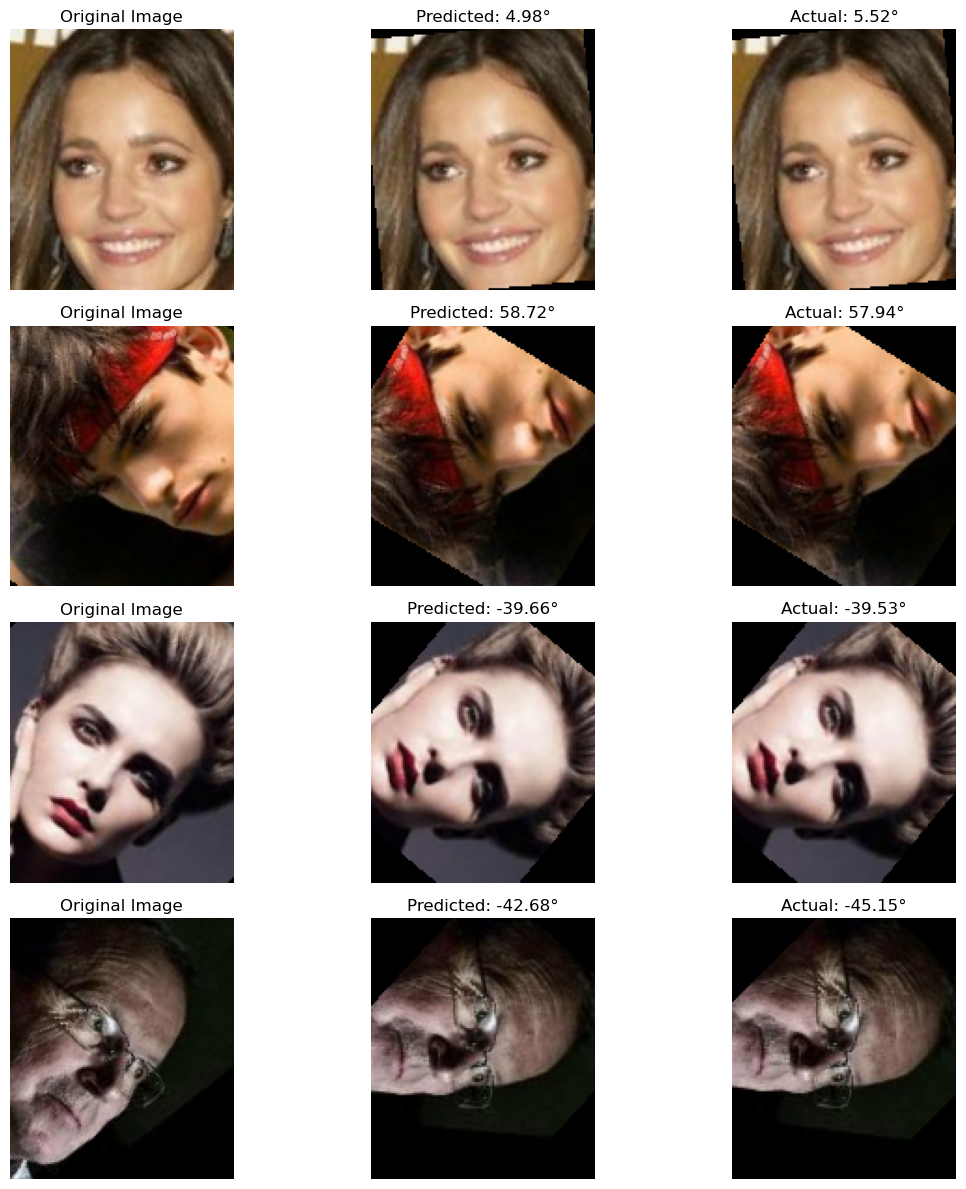

In [21]:
num_samples = 4
test_images = test_rot_ds.take(num_samples)  

fig, axes = plt.subplots(num_samples, 3, figsize=(12, 12))

for i, (image, actual_rotation) in enumerate(test_images):
    # ensure image has batch dimension
    image_batch = tf.expand_dims(image, axis=0) 

    # predict rotation using model
    predicted_rotation = model.predict(image_batch)[0][0]

    # actually rotate images
    predicted_image = rot_resize(image.numpy(), predicted_rotation)
    target_image = rot_resize(image.numpy(), actual_rotation.numpy())

    # original image
    axes[i, 0].imshow(image.numpy().squeeze(), cmap="gray")
    axes[i, 0].set_title("Original Image")
    axes[i, 0].axis("off")

    # straightened image
    axes[i, 1].imshow(predicted_image.squeeze(), cmap="gray")
    axes[i, 1].set_title(f"Predicted: {predicted_rotation:.2f}°")
    axes[i, 1].axis("off")

    # target straightened image
    axes[i, 2].imshow(target_image.squeeze(), cmap="gray")
    axes[i, 2].set_title(f"Actual: {actual_rotation.numpy():.2f}°")
    axes[i, 2].axis("off")
plt.tight_layout()
plt.show()


<!-- BEGIN QUESTION -->

<div class='exercise'>
<a id="q23"></a>
<b>2.3 Further Analysis</b>
<hr>
<b>Q2.3.1 Correct an image of your choosing</b>

<a id="q231"></a>

Find an image or image(s) (not from the provided test/training sets), or make your own; it does not necessarily have to be a human face. You may rotate it yourself up to $\pm60^\circ$, or the face can already be naturally rotated. Resize and crop the image to 140px by 120px, load it here, and normalize it to [0.,1.], and use your network to correct it.

![Confused Chris](data/chrisprattcorrection.png)
    
**Note:** Please do *not* upload your custom image as a separate file with your notebook submission. It is sufficient to display your results in the cell output.
    </div>

1/1 [==============================] - 0s 17ms/step


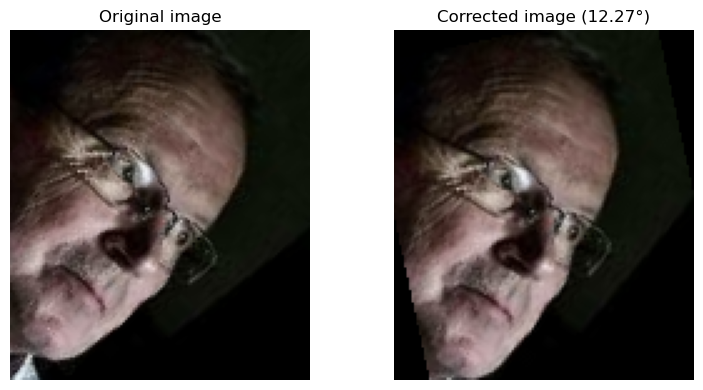

In [22]:
from PIL import Image

image_path = "data/chrisprattcorrection.png" 

# normalize + add batch dimension
image_array = np.array(image) / 255.0 
image_array = np.expand_dims(image_array, axis=0)  

predicted_rotation = model.predict(image_array)[0][0]

corrected_image = rot_resize(image, predicted_rotation)

fig, axes = plt.subplots(1, 2, figsize=(8, 4))

axes[0].imshow(image)
axes[0].set_title("Original image")
axes[0].axis("off")

axes[1].imshow(corrected_image)
axes[1].set_title(f"Corrected image ({predicted_rotation:.2f}°)")
axes[1].axis("off")

plt.tight_layout()
plt.show()


<a id="part3"></a>
    
<!-- <div class="alert alert-block alert-danger" style="color:black;background-color:#E7F4FA"> -->

# PART 3: Image Segmentation
<a id="part3intro"></a>
## Overview

[Return to contents](#contents)

In this section, we will use the Oxford-IIIT Pet dataset to design a model for an image segmentation task.

[Semantic image segmentation](https://arxiv.org/abs/2302.06378) is a computer vision application where we assign a semantically meaningful label, or class, to every pixel in the image. For example, a camera on a self-driving car would segment the imagery around it into semantic labels such as "Road", "Person", "Bike", etc.

Our  dataset contains images of various pet breeds along with their corresponding segmentation masks. Each raw image is 500x403 with three RGB channels, while the corresponding mask is of the same size but contains only a single channel, indicating the pixel class.

For simplicity, we resize both the images and masks to 64x64 to speed up training.
We have also have provided all the necessary preprocessing code for you as well as some functions for visualization.

In [23]:
# Load the dataset with tensorflow-datasets
ds_source = tfds.load(
    'oxford_iiit_pet',
    split='test', # train set has corrupted images :(
    as_supervised=False, # we done need the dog breed labels
    download=True,
)

# Check the first example
example = next(iter(ds_source))
print(example.keys())
print(f"The raw image shape is: {example['image'].shape}")
print(f"The raw segmentation mask shape is: {example['segmentation_mask'].shape}")

dict_keys(['file_name', 'image', 'label', 'segmentation_mask', 'species'])
The raw image shape is: (500, 403, 3)
The raw segmentation mask shape is: (500, 403, 1)


In [24]:
def preprocess(sample, reduce_class=False, resize_dim=64):
    """
    Complete preprocessing function that:
    1. Resizes image and mask to (resize_dim, resize_dim)
    2. Normalizes image to [0,1] range
    3. Remaps class indices to be more intuitive
    4. Optionally reduces to 2 classes
    5. Clips pixel values in case of corrupted jpegs
    6. Returns (image, mask) tuple
    """
    image = sample['image']
    mask = sample['segmentation_mask']

    # Resize using bilinear interpolation for image and nearest neighbor for mask
    image = tf.image.resize(image, [resize_dim, resize_dim], method='bilinear')
    mask = tf.image.resize(mask, [resize_dim, resize_dim], method='nearest')

    # Normalize the image: convert from [0, 255] to [0, 1]
    image = tf.cast(image, tf.float32) / 255.0

    # Convert mask values from 1-indexed to 0-indexed
    mask = tf.cast(mask, tf.int32) - 1

    # Remap classes to be more intuitive
    # Current: 0-pet border, 1-background, 2-pet interior
    # Desired: 0-background, 1-border, 2-center
    new_mask = tf.zeros_like(mask)
    new_mask = tf.where(mask == 1, 0, new_mask)  # Map old background (1) to new background (0)
    new_mask = tf.where(mask == 0, 1, new_mask)  # Map old border (0) to new border (1) 
    new_mask = tf.where(mask == 2, 2, new_mask)  # Keep center as class 2
    
    # Reduce problem difficulty if requested
    if reduce_class:
        # Combine border and center into a single "pet" class
        # Now we have: 0-background, 1-pet (both border and center)
        new_mask = tf.where(new_mask > 0, 1, 0)

    # Handle corrupt JPEG data by ensuring valid values
    image = tf.clip_by_value(image, 0.0, 1.0)

    # Always return (image, mask) tuple
    return image, new_mask

In [25]:
# Helper functions for visualization
def visualize_image_and_mask(dataset, num_examples=5):
    """Visualizes image and segmentation mask pairs from the dataset."""
    for i, (image, mask) in enumerate(dataset.take(num_examples)):
        # Convert to numpy arrays
        image = image.numpy()
        mask = mask.numpy().squeeze()
        
        # Convert normalized image to uint8 for display
        if image.dtype == np.float32 and image.max() <= 1.0:
            display_image = (image * 255.0).astype('uint8')
        else:
            display_image = image.astype('uint8')
        
        mask = mask.astype(int)
        
        # Visualize
        plt.figure(figsize=(8, 4))

        # Plot the image
        plt.subplot(1, 2, 1)
        plt.imshow(display_image)
        plt.title("Image")
        plt.axis("off")

        # Plot the segmentation mask
        plt.subplot(1, 2, 2)
        cmap_choice = 'gray' if mask.max() <= 1 else 'viridis'
        plt.imshow(mask, cmap=cmap_choice, vmin=0, vmax=mask.max())
        plt.title("Segmentation Mask")
        plt.axis("off")

def visualize_predictions(dataset, model, num_examples=5, threshold=0.5, show_iou=False):
    """
    Visualizes predictions from a segmentation model alongside ground truth.
    
    Args:
        dataset: TensorFlow dataset containing images and masks
        model: Trained segmentation model
        num_examples: Number of examples to visualize
        threshold: Threshold for binarizing predictions (default: 0.5)
        show_iou: Whether to compute and display IoU metrics (default: False)
    """
    shuffled_dataset = dataset.shuffle(buffer_size=200)
    
    for i, (images, masks) in enumerate(shuffled_dataset.take(num_examples)):
        # Check if the dataset is batched
        if len(images.shape) == 4:  # Batched data
            batch_size = images.shape[0]
            random_index = np.random.randint(0, batch_size)
            image_for_pred = images[random_index]
            mask = masks[random_index]
        else:  # Unbatched data
            image_for_pred = images
            mask = masks
            
        # Convert to numpy and prepare for display
        display_image = (image_for_pred * 255.0).numpy().astype('uint8')
        
        # Predict the segmentation mask
        with tf.device('/CPU:0'):
            pred_mask = model.predict(image_for_pred[tf.newaxis, ...], verbose=0)
        
        # extract single-channel mask and apply thresholding
        pred_mask = pred_mask[0, ..., 0]  # Extract single-channel mask
        pred_mask_binary = (pred_mask > threshold).astype(np.uint8)
        
        # Convert ground truth mask to numpy
        true_mask = mask.numpy().squeeze()
        
        # Calculate pixel-wise accuracy
        accuracy = (true_mask == pred_mask_binary).mean()
        
        # Visualize
        plt.figure(figsize=(12, 4))
        
        # Plot the input image
        plt.subplot(1, 3, 1)
        plt.imshow(display_image)
        plt.title("Input Image")
        plt.axis("off")
        
        # Plot the ground truth mask
        plt.subplot(1, 3, 2)
        plt.imshow(true_mask, cmap='gray', vmin=0, vmax=1)
        plt.title("Ground Truth Mask")
        plt.axis("off")
        
        # Plot the predicted mask with metrics in the title
        plt.subplot(1, 3, 3)
        plt.imshow(pred_mask_binary, cmap='gray', vmin=0, vmax=1)
        
        if show_iou:
            # Calculate IoU for this example
            intersection = np.logical_and(true_mask, pred_mask_binary).sum()
            union = np.logical_or(true_mask, pred_mask_binary).sum()
            iou = intersection / union if union > 0 else 1.0
            plt.title(f"Predicted Mask\nAcc: {accuracy:.2%} | IoU: {iou:.2%}")
        else:
            plt.title(f"Predicted Mask\nAcc: {accuracy:.2%}")
            
        plt.axis("off")
        plt.tight_layout()


I added thresholding to the visualizing function because before, the model would predict all black images. This is because low pixel values may have been interpreted as 0's. By applying a threshold, we force pixels above threshold to become 1 (white, pet pixels), and pixels below remain 0 (black, background)! Due to class imbalance my model was likely biased toward predicting the background before.

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q3.1 Deep CNN for Image Segmentation</b>

<a id="q31"></a>

Here you'll design a segmentation model that utilizes convolutional layers and skip connections. The model should perform a binary classification task, predicting the class for each pixel which is compared to the ground truth segmentation mask. 

Minimum Requirements:
- A reasonably deep CNN architecture (you should be able to get above 80% validation accuracy with only 90 seconds of training)
- Accepts an input size of 64 × 64 × 3 and performs pixel-level binary classification.
- At least four skip connections placed appropriately.
- Compile the model with an appropriate loss function and include accuracy as an evaluation metric.
- Set the model name to `model_deepcnn`
- Assign the result of `model_deepcnn.fit()` to a variable named `history_model_deepcnn`.

We've created a train and validation set for you below.

**HINT:** Typically, for binary classification we utilize the sigmoid activation function with a single output unit. That can be an appropriate method for this task as well, where we have a single output filter. However, considering a 2-class classification with a softmax activation function and two output units will also work. You may find a difference in performance between the two methods. Be sure you are selecting the appropriate loss for your choice.
    </div>

In [26]:
# Create processed binary segmentation dataset
ds_2c = ds_source.map(lambda sample: preprocess(sample, reduce_class=True),
                               num_parallel_calls=tf.data.AUTOTUNE)
# 85/15 train-test split
ds_2c_train, ds_2c_test = tf.keras.utils.split_dataset(ds_2c, left_size=0.85)
# Reserve 20% of train as validation
ds_2c_train, ds_2c_val = tf.keras.utils.split_dataset(ds_2c, left_size=0.80)

# Dataset sizes
print("Train:", ds_2c_train.cardinality().numpy())
print("Validation:", ds_2c_val.cardinality().numpy())
print("Test:", ds_2c_test.cardinality().numpy())

Train: 2935
Validation: 734
Test: 550


Here are some of the images and their corresponding segmentation masks. The segmentation mask categorizes each pixel into two classes: "background" or "pet".

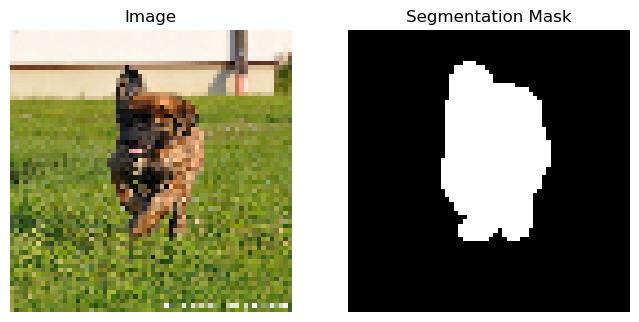

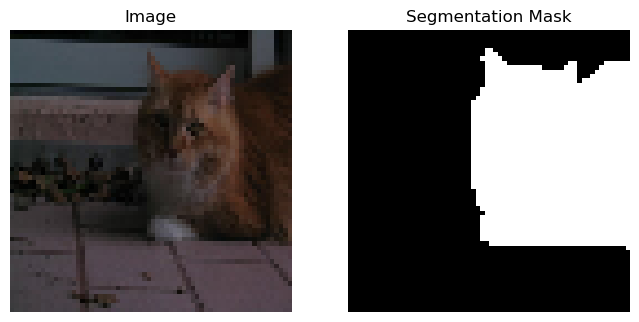

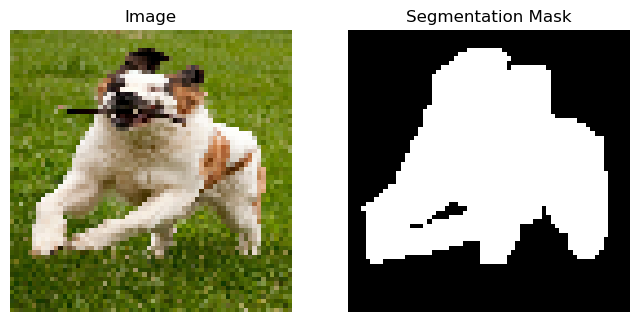

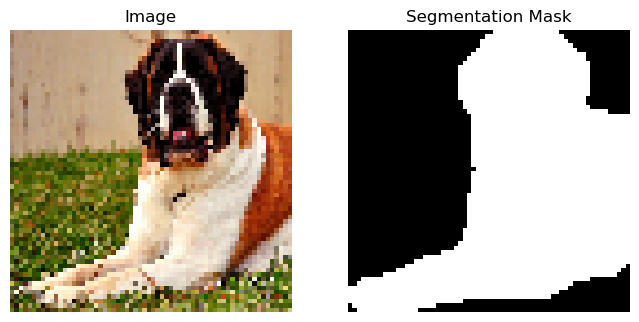

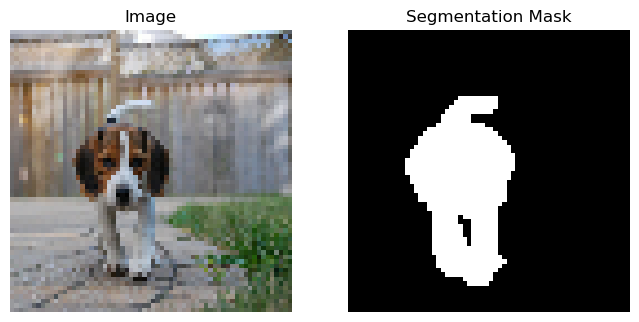

In [27]:
# Visualize 5 examples from the training split
visualize_image_and_mask(ds_2c_train)

In [28]:
from tensorflow import keras
from tensorflow.keras import layers
def build_deepcnn_model(input_shape=(64, 64, 3)):
    inputs = keras.Input(shape=input_shape)
    
    # encoder 
    conv1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D((2, 2))(conv1)
    
    conv2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D((2, 2))(conv2)
    
    conv3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = layers.MaxPooling2D((2, 2))(conv3)
    
    # bottleneck
    bottleneck = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    bottleneck = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(bottleneck)
    
    # decoder
    up3 = layers.UpSampling2D((2, 2))(bottleneck)
    concat3 = layers.Concatenate()([up3, conv3])  # skip connection
    conv4 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(concat3)
    conv4 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv4)
    
    up2 = layers.UpSampling2D((2, 2))(conv4)
    concat2 = layers.Concatenate()([up2, conv2])  
    conv5 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(concat2)
    conv5 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv5)
    
    up1 = layers.UpSampling2D((2, 2))(conv5)
    concat1 = layers.Concatenate()([up1, conv1])
    conv6 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(concat1)
    conv6 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(conv6)
    
    # output layer 
    output = layers.Conv2D(1, (1, 1), activation='sigmoid')(conv6)  # sigmoid b/c binary classification
    
    model = keras.Model(inputs, output, name="model_deepcnn")
    return model

model_deepcnn = build_deepcnn_model()

model_deepcnn.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model_deepcnn.summary()

Model: "model_deepcnn"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 conv2d_83 (Conv2D)          (None, 64, 64, 32)           896       ['input_2[0][0]']             
                                                                                                  
 conv2d_84 (Conv2D)          (None, 64, 64, 32)           9248      ['conv2d_83[0][0]']           
                                                                                                  
 max_pooling2d_33 (MaxPooli  (None, 32, 32, 32)           0         ['conv2d_84[0][0]']           
 ng2D)                                                                                

In [29]:
BATCH_SIZE = 32

train_dataset = ds_2c_train.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset = ds_2c_val.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

history_model_deepcnn = model_deepcnn.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,  
    verbose=1
)


Epoch 1/10
92/92 [==============================] - 8s 38ms/step - loss: 0.6048 - accuracy: 0.6455 - val_loss: 0.5328 - val_accuracy: 0.7595
Epoch 2/10
92/92 [==============================] - 2s 17ms/step - loss: 0.4472 - accuracy: 0.7952 - val_loss: 0.3714 - val_accuracy: 0.8349
Epoch 3/10
92/92 [==============================] - 2s 17ms/step - loss: 0.3624 - accuracy: 0.8406 - val_loss: 0.3249 - val_accuracy: 0.8589
Epoch 4/10
92/92 [==============================] - 2s 17ms/step - loss: 0.3239 - accuracy: 0.8610 - val_loss: 0.3069 - val_accuracy: 0.8683
Epoch 5/10
92/92 [==============================] - 2s 17ms/step - loss: 0.3063 - accuracy: 0.8702 - val_loss: 0.2868 - val_accuracy: 0.8781
Epoch 6/10
92/92 [==============================] - 2s 17ms/step - loss: 0.2857 - accuracy: 0.8794 - val_loss: 0.2854 - val_accuracy: 0.8791
Epoch 7/10
92/92 [==============================] - 2s 17ms/step - loss: 0.2688 - accuracy: 0.8876 - val_loss: 0.2793 - val_accuracy: 0.8840
Epoch 8/10
92

Run the cell below to visualize your loss and accuracy.

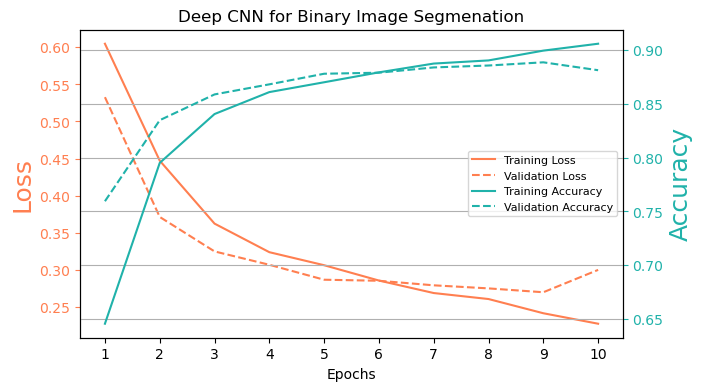

In [30]:
def plot_training_history(model_history_object, model_name=''):
    # Extract the training history dictionary
    hist_dict = model_history_object.history
    # Plot
    plt.figure(figsize=(7, 4))
    loss_color = 'coral'
    # Plot Loss on the primary y-axis
    loss_plot, = plt.plot(hist_dict['loss'],
                          label='Training Loss', color=loss_color)
    val_loss_plot, = plt.plot(hist_dict['val_loss'],
                              label='Validation Loss', color=loss_color, linestyle='--')
    
    # Label for the primary y-axis (Loss)
    plt.ylabel('Loss', color=loss_color, fontsize=18)
    plt.gca().tick_params(axis='y', colors=loss_color)
    ticks = range(0, len(hist_dict['loss'])+1)
    plt.xticks(ticks=ticks, labels=[x+1 for x in ticks])
    plt.xlabel('Epochs')  # X-axis label
    plt.title(model_name)
    
    # Create a secondary y-axis for Accuracy
    acc_color = 'lightseagreen'
    ax2 = plt.gca().twinx()
    train_acc = hist_dict.get('accuracy', hist_dict.get('acc'))
    val_acc = hist_dict.get('val_accuracy', hist_dict.get('val_acc'))
    accuracy_plot, = ax2.plot(train_acc,
                              label='Training Accuracy', color=acc_color)
    val_accuracy_plot, = ax2.plot(val_acc,
                                  label='Validation Accuracy', color=acc_color, linestyle='--')
    ax2.set_ylabel('Accuracy', color=acc_color, fontsize=18)
    ax2.tick_params(axis='y', colors=acc_color)
    
    plt.grid()
    lines = [loss_plot, val_loss_plot, accuracy_plot, val_accuracy_plot]
    labels = [line.get_label() for line in lines]
    plt.legend(lines, labels, loc='right', fontsize=8);

plot_training_history(history_model_deepcnn, model_name="Deep CNN for Binary Image Segmenation")

Run the cell below, and you will see your segmentation result. You can run the cell multiple times to see different result sets.

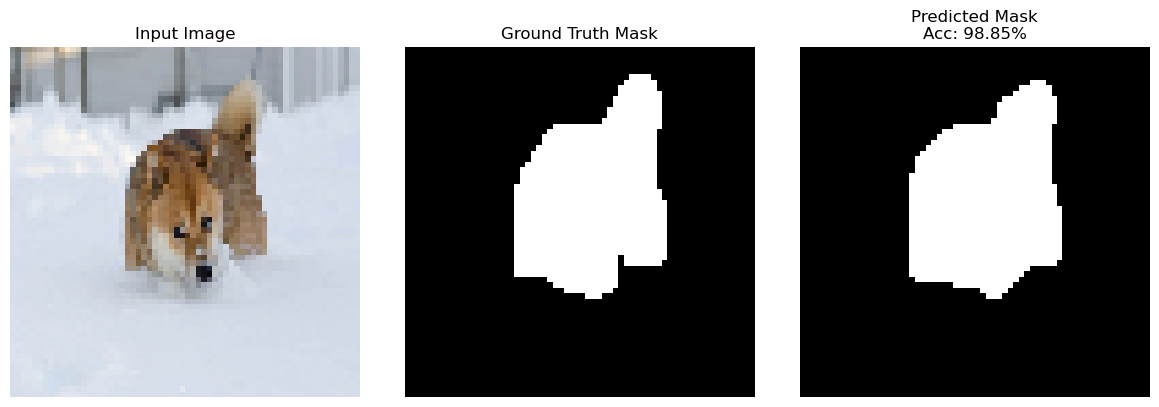

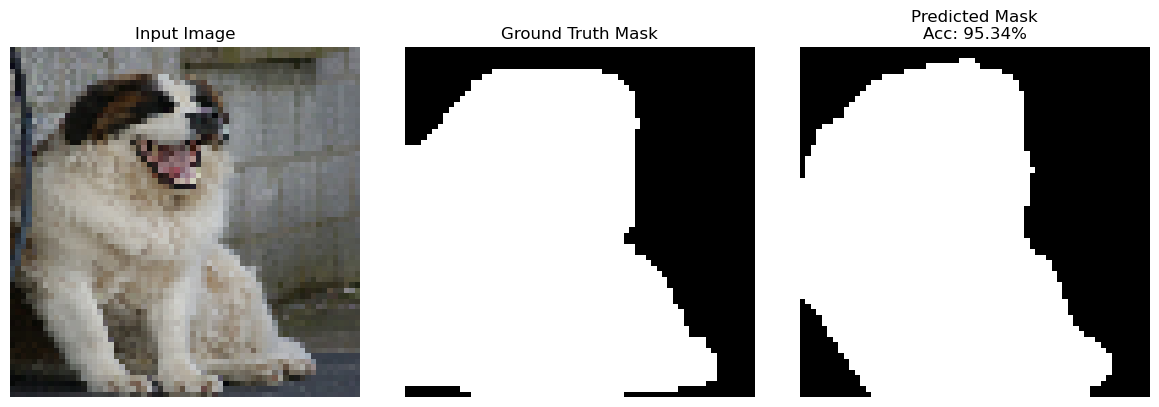

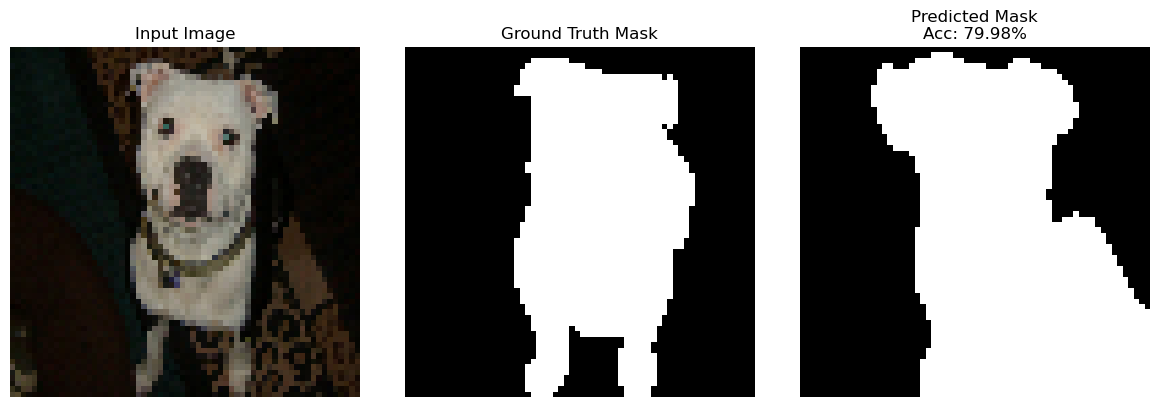

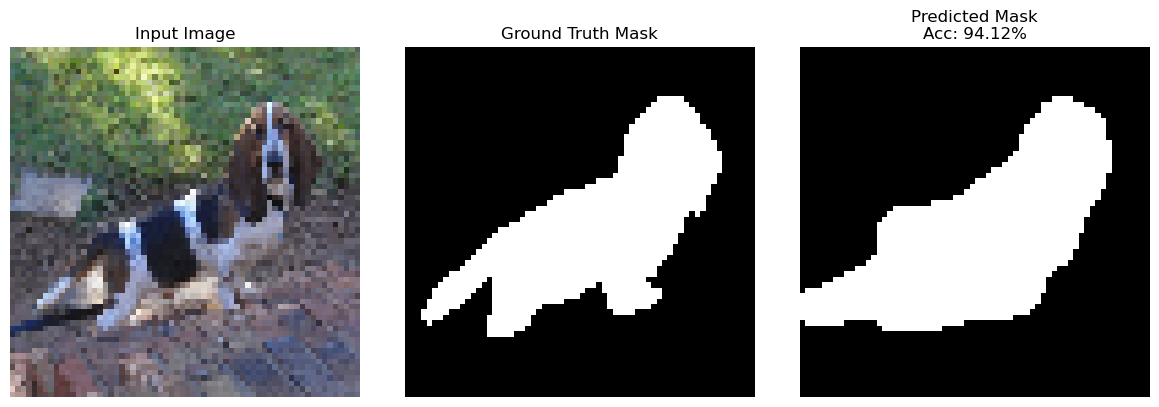

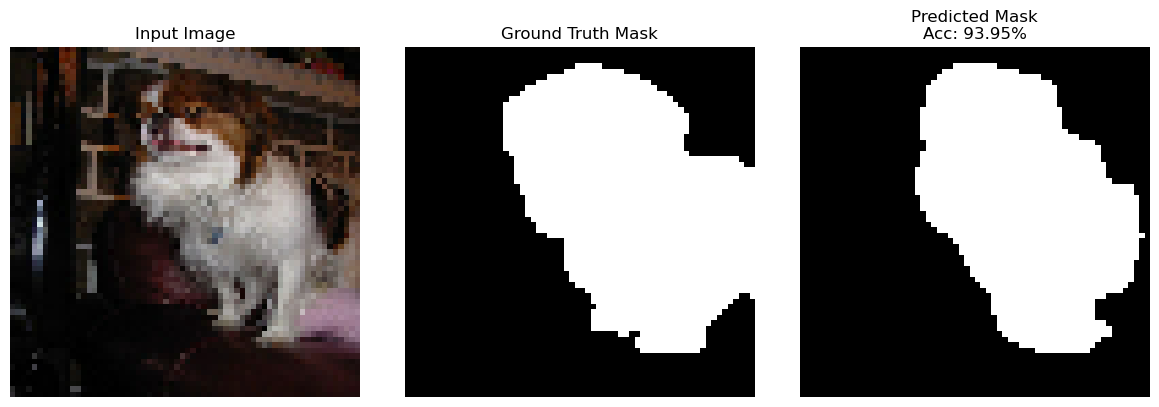

In [31]:
visualize_predictions(ds_2c_test, model_deepcnn)

<div class='exercise'><b>[209] Q3.2 U-Net for 3-Class Image Segmentation</b>

<a id="q32"></a>  
This question is required for 209 students but optional for others. Extra credit will not be given if attempted by non-209 students, but you may learn something new! :) 

In the previous model, the predictions were limited because we had to maintain the same dimensions throughout. This restricted the ability to capture different levels of detail. To address this, we introduce a new architecture: **U-Net**.  

U-Net is a segmentation model originally designed for biomedical image segmentation. It follows an encoder-decoder structure with skip connections, allowing it to capture both fine details and high-level semantic features. This structure makes U-Net highly effective for pixel-wise classification. To learn more, please see:

- [ED Slides and Notebook](https://edstem.org/us/courses/74185/lessons/133380/slides/750646)
- **Reference Paper:** [U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/pdf/1505.04597)  

You will build a U-Net model that takes a 64 × 64 × 3 image as input and classifies each pixel into one of three categories:  
- Background  
- Border-of-Pet
- Pet  

In the previous model, accuracy was used as a metric. However, for segmentation tasks, accuracy can be misleading. A model predicting all pixels as "background" could still appear accurate if there is a data imbalance. Instead, consider exploring alternative metrics. 
Refer to the links above for different approaches.  

Minimum Requirements: \
To complete this task successfully, your model must:  
- Follow an encoder-decoder architecture.  
- Accept 64 × 64 × 3 input images and perform pixel-level 3-class classification.  
- Include exactly three downsampling operations in the encoder, reducing the size as follows:  
  - 64 -> 32 -> 16 -> 8  
- Use a decoder that mirrors the encoder, upsampling back to 64 × 64.  
- Implement at least three skip connections appropriately.  
- Compile with an appropriate loss function and include accuracy as an evaluation metric.  
- Name your model `model_unet`.  
- Assign the result of `model_unet.fit()` to a named `history_model_unet`.  


With a well-optimized model following the requirements above, you should be able above 80% validation accuracy within 4-5 minutes of training. If training takes significantly longer or the model performs poorly, you should inspect your the architecture and/or loss function.
</div>

In [32]:
# Create processed 3-class segmentation dataset
ds_3c = ds_source.map(lambda sample: preprocess(sample, reduce_class=False),
                               num_parallel_calls=tf.data.AUTOTUNE)

# 85/15 train-test split
ds_3c_train, ds_3c_test = tf.keras.utils.split_dataset(ds_3c, left_size=0.85)
# Reserve 20% of train as validation
ds_3c_train, ds_3c_val = tf.keras.utils.split_dataset(ds_3c_train, left_size=0.80)

# Dataset sizes
print("Train:", ds_3c_train.cardinality().numpy())
print("Validation:", ds_3c_val.cardinality().numpy())
print("Test:", ds_3c_test.cardinality().numpy())

Train: 2495
Validation: 624
Test: 550


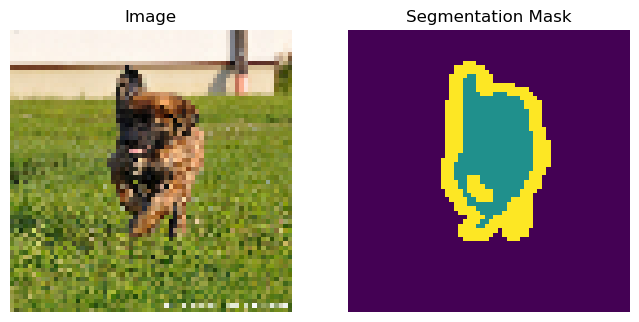

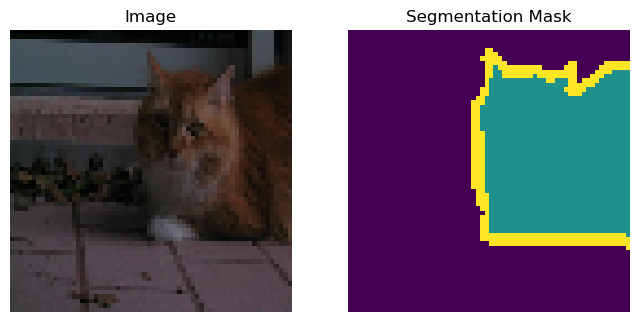

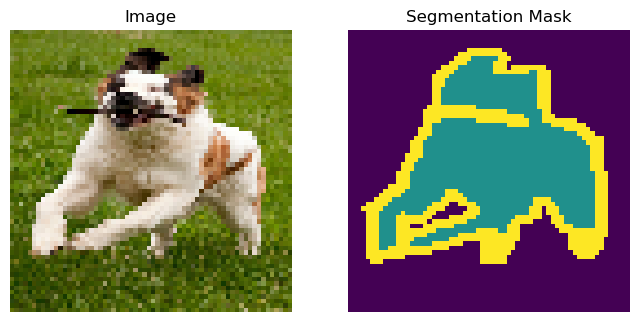

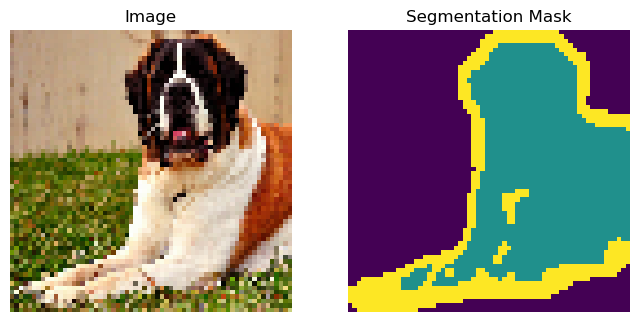

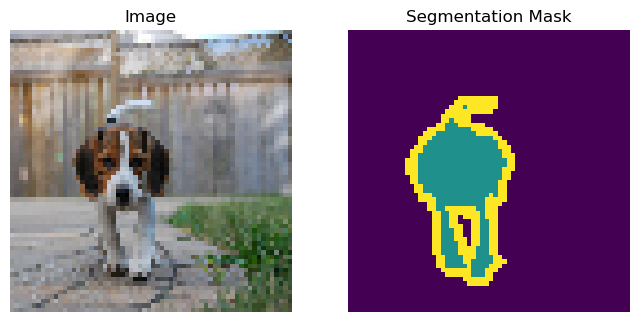

In [33]:
# Visualize 5 examples from the training split
visualize_image_and_mask(ds_3c_train)

In [34]:
# your code here
...

Run the cell below to visualize your loss and accuracy.

In [38]:
plot_training_history(history_model_unet,
                      model_name="U-Net for 3-Class Image Segmentation")

NameError: name 'history_model_unet' is not defined

Run the cell below, and you will see your segmentation result. You can run the cell multiple times to see different result sets.

In [35]:
visualize_predictions(ds_3c_test, model_unet, show_iou=True)

NameError: name 'model_unet' is not defined

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Wrap-up</b>

* In a few sentences, please describe the aspect(s) of the assignment you found most challenging. This could be conceptual and/or related to coding and implementation.

* How many hours did you spend working on this assignment? Store this as an int or float in `hours_spent_on_hw`. If you worked on the project in a group, report the *average* time spent per person.
    </div>

I like these homeworks where we have a lot of flexibility on model architecture! One of the most challenging aspects of the assignment was definitely getting the last model to work because the predictions were just black masks, so I had to debug a lot and see what was going wrong logically. Ultimately I learned to carefully examine my models, experiment w/ hyperparameters, and debug things like threshold levels and class weights!


In [32]:
hours_spent_on_hw = 17

In [33]:
grader.check("wrapup")

wrapup results: All test cases passed!

In [34]:
time_end = time.time()
print(f"It took {(time_end - time_start)/60:.2f} minutes for this notebook to run")

It took 38.32 minutes for this notebook to run


**This concludes HW3. Thank you!**